<a href="https://colab.research.google.com/github/jhcool1988/teamdata/blob/master/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pandas import Series


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/ljg-95/bigdataset1/master/son2.csv',parse_dates = ['index'], index_col = ['index'])
df.head()

,min,gls,agls,assist,sh,ash,shgls,ashgls,cmpp,sca,press,pressp,touches,targ,Unnamed: 15,Unnamed: 16
index,,,,,,,,,,,,,,,,
1.0,29.0,1.0,1.0,0.0,2.1,2.1,0.47619,0.476190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,90.0,1.0,2.0,0.0,2.1,4.2,0.47619,0.476190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,76.0,0.0,2.0,0.0,1.0,5.2,0.00000,0.384615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,90.0,1.0,3.0,0.0,2.1,7.3,0.47619,0.410959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,45.0,0.0,3.0,0.0,0.0,7.3,0.00000,0.410959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df1 = df['ashgls']
df1.isna().sum()
df1.dropna(axis=0,how='all',inplace=True)
df2 = pd.DataFrame(df1,columns=[ 'ashgls'])
df2.index = pd.date_range('2011-01-01', periods=len(df2), freq='D')


df2

,ashgls
2011-01-01,0.476190
2011-01-02,0.476190
2011-01-03,0.384615
2011-01-04,0.410959
2011-01-05,0.410959
...,...
2011-11-21,0.164383
2011-11-22,0.165080
2011-11-23,0.165999
2011-11-24,0.165545


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 329 entries, 2011-01-01 to 2011-11-25
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ashgls  329 non-null    float64
dtypes: float64(1)
memory usage: 5.1 KB


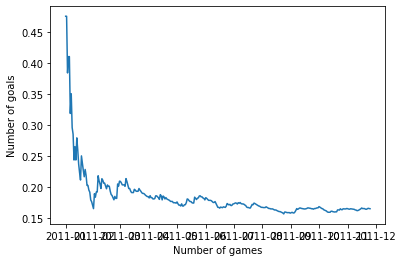

In [ ]:
plt.xlabel('Number of games')
plt.ylabel('Number of goals')
plt.plot(df2)

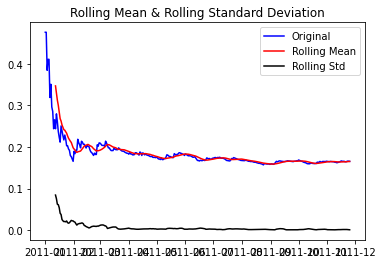

In [ ]:
rolling_mean = df2.rolling(window = 12).mean()
rolling_std = df2.rolling(window = 12).std()
plt.plot(df2, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

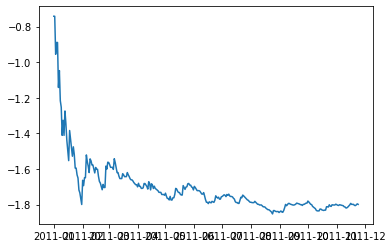

In [ ]:
df_log = np.log(df2)[:-1]
plt.plot(df_log)

In [ ]:
result = adfuller(df2['ashgls'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.0491212562465124
p-value: 0.03055482276465343
Critical Values:
	1%: -3.4513486122290717
	5%: -2.870789013306053
	10%: -2.5716978530569192


In [ ]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['ashgls'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

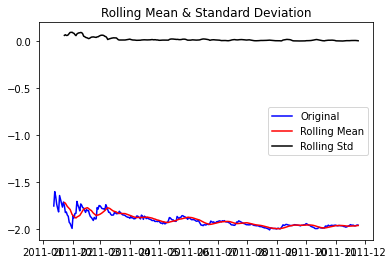

ADF Statistic: -1.2048508155029571
p-value: 0.6715055402519803
Critical Values:
	1%: -3.4524113009049935
	5%: -2.8712554127251764
	10%: -2.571946570731871


In [ ]:
rolling_mean = df2.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

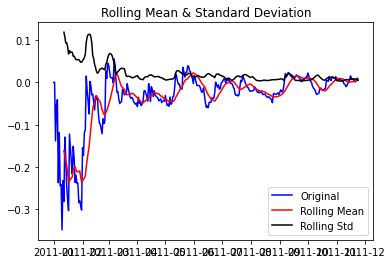

ADF Statistic: -3.7186812665727307
p-value: 0.0038579281457332823
Critical Values:
	1%: -3.451552879535732
	5%: -2.8708786756338407
	10%: -2.571745666091128


In [ ]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

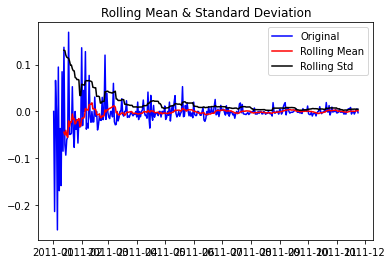

ADF Statistic: -4.720871843764467
p-value: 7.68748672356686e-05
Critical Values:
	1%: -3.45169128009473
	5%: -2.8709394227049154
	10%: -2.5717780602423517


In [ ]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(axis=0,how='all',inplace=True)
get_stationarity(df_log_shift)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


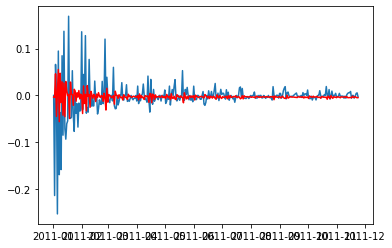

In [ ]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(3,1,1))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')


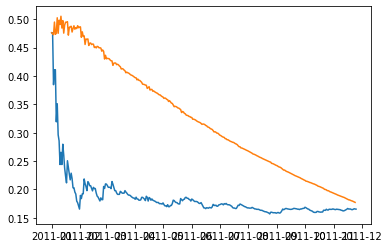

In [ ]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['ashgls'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df2)
plt.plot(predictions_ARIMA)

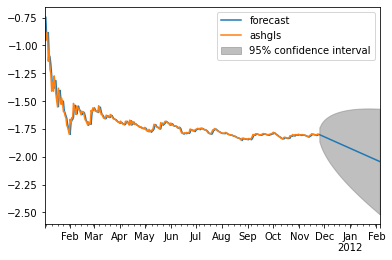

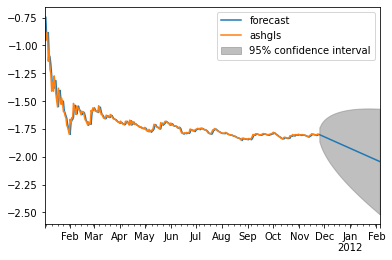

In [ ]:
results.plot_predict(1,400)